## Homomorphic filtering in the frequency domain
The goal of homomorphic filtering is to even out the lighting in an image. The intensity value of each pixel consists of an ambient light (illuminance), and a reflected light (reflectance). The frequency of the the illuminance is usually low, because it is more evenly spread out and diffused, whereas the reflectance, which highlights details and edges, has a much higher frequency. By doing a high pass filter, we let through the higher frequencies preserving the details in the picture, while evening out the ambient light and avoiding too dark or too bright areas.

width x height: 403 x 451


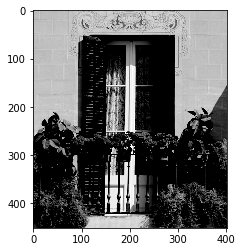

In [59]:
%matplotlib inline

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

pil_image = Image.open('image.png')
image = np.array(pil_image, dtype=np.float32)[:,:,0]
image /= 255 # normalize the image
height, width = image.shape
print("width x height: %d x %d" % (width, height))
plt.imshow(image, cmap='gray')

Homomorphic filtering is based on a multiplicative lighting model, where the the intensity (f) can be represented as the product of the ambient illuminance intensity (i) and the reflective intensity (r):

$f = ir$

We cannot do a high pass filter right away, because the intensities are multiplied and not added in our model. By moving to the logarithmic domain, our model becomes additive, due to the properties of logarithms:

$ln(f) = ln(ir) = ln(i) + ln(r)$

In [60]:
log_image = np.log(1 + image)

While the frequencies are additive, we can do the filtering. Because the filtering process is commutative (elementwise multiplication), and we can filter both the illuminance and reflectance, instead of the product.

We will do the high pass filtering in the frequency domain by doing a Fourier transform, because convolution is equivalent to elementwise multiplication in the frequency domain:

$ A * H = \mathcal{F}^{-1}(\mathcal{F}(A)\mathcal{F}(H)) $

The size of the matrices will be $M = 2 * height + 1$ and $N = 2 * width + 1$

In [61]:
M = 2 * height + 1
N = 2 * width + 1
print("M: %d, N: %d" % (M, N))

M: 903, N: 807


The frequency response of a Gaussean high pass filter in 2 dimensions is

$g_f(u, v) = 1 - e^{-\frac{(\frac{M}{2}-u)^2+(\frac{N}{2}-v)}{2\sigma^{2}}}$

H shape: (903, 807)


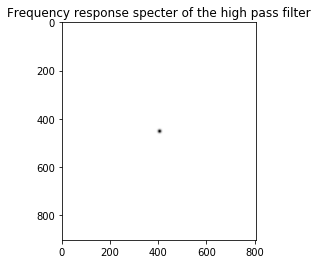

In [62]:
sigma = 5

def g(u, v):
    return 1 - np.exp(-(((M/2) - u)**2 + ((N/2) - v)**2)/(2*sigma**2))

H = np.fromiter((g(u, v) for u, v in np.ndindex((M, N))), dtype=np.float32)\
      .reshape((M, N))

print("H shape:", H.shape)
plt.title("Frequency response specter of the high pass filter")
plt.imshow(H, cmap='gray')
H = np.fft.fftshift(H) # shift H to uncentered

Fourier transform of image using fft2 and shifting the low frequencies to the center

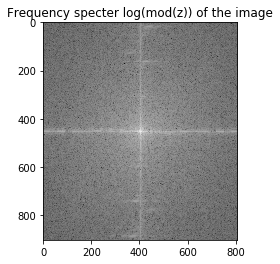

In [63]:
A = np.fft.fft2(log_image, (M, N)) # shift to center
plt.title("Frequency specter log(mod(z)) of the image")
plt.imshow(np.log(np.abs(np.fft.ifftshift(A))),  cmap='gray') # plot the log of the modulus

Applying the filter is now the simple process of performing elementwise multiplication of the two matrices

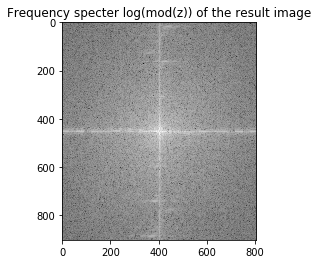

In [64]:
R = np.multiply(H, A)
plt.title("Frequency specter log(mod(z)) of the result image")
plt.imshow(np.log(np.abs(np.fft.ifftshift(R))),  cmap='gray') # plot the log of the modulus

Perform the inverse fourier transform to get the image back in the time or pixel domain, and use the exponential function to revert the logarithm.

Text(0.5,1,'After')

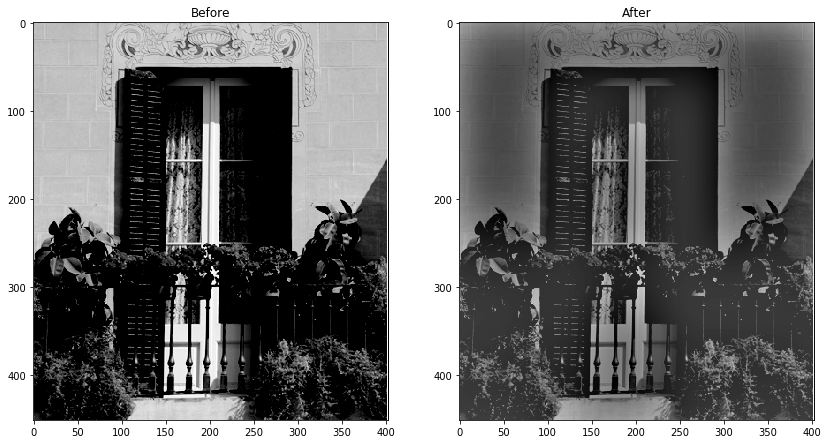

In [65]:
log_result_image = np.fft.ifft2(R)
log_result_image = np.real(log_result_image)
log_result_image = log_result_image[:height,:width]
result_image = np.exp(log_result_image) - 1
m = np.min(result_image)
if m < 0:
    result_image -= m
    result_image /= 1 - m
plt.figure(figsize=(14, 10))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Before")
plt.subplot(1, 2, 2)
plt.imshow(result_image, cmap='gray')
plt.title("After")